# Properly generating the dataset

Since ```prmon``` burner tests only provide a way to put a constant load on cpu or I/O during each test, we should attentively approach the matter of generating data for the task. It will be very easy (and unrealistic) to consider a data series with plain load on all devices, and only short eventual bumps for anomalies.

The first step is adding some noise to the ```prmon``` data, that is allocating ```memory_amount``` + ```noise```, where noise can be just white gaussian noise.

The second step is adding some noise to ```nprocs``` and ```nthreads``` so that load would seem realistic.

We will generate data so that 95% of it are integers normally distributed in the range ```[a, b]```, with the mean $\mu = (a+b)/2$ and $\sigma=(b-a)/4$. We will call this distribution $\mathcal{P}(a, b)$

Thus, the loads under normal regime are the following:

*   Memory consumption follows  $\mathcal{P}(290, 310)$
*   nprocs ~ $\mathcal{P}(2, 4)$
*   nthreads ~ $\mathcal{P}(2, 4)$

In the current setting, dataset is generated by ```generate.py``` module. It then outputs ```dataset.csv``` containing time-series data and ```anomalies.csv``` containing anomalies start time and duration.

# Injecting anomalies into the dataset

We now want to generate a certain amount of artificial anomalies in our dataset. As our time series is multivariate, we can create 3 types of anomalies, one for each variable's anomal behaviour. We can proceed as follows:


1.   Memory anomaly:
      *   Memory ~ $\mathcal{P}(600, 700)$
      *   nprocs ~ $\mathcal{P}(2, 5)$
      *   nthreads ~ $\mathcal{P}(3, 6)$

2.   Process anomaly:
      *   Memory ~ $\mathcal{P}(420, 550)$
      *   nprocs ~ $\mathcal{P}(6, 10)$
      *   nthreads ~ $\mathcal{P}(4, 7)$

3. Thread anomaly
      *   Memory ~ $\mathcal{P}(380, 420)$
      *   nprocs ~ $\mathcal{P}(4, 8)$
      *   nthreads ~ $\mathcal{P}(5, 10)$

Note that it actually makes sense to change all the variable during one variable's anomal behaviour, as those are correlated. In reality, memory consumption is often followed bigger thread consumption. Conversely, bigger process and thread consumption leads to bigger memory consumption.
Here are key variables and library dependencies used throughout the task:

In [1]:
nsamples = 3000 # Data samples count
# The actual count is ~3003 as prmon time measurement is not absolutely exact
contamination = 0.05 # Data contamination rate
anomaly_count = 15
anomaly_duration = 10
anomaly_spacing = 60 # Minimal spacing between anomalies

In [70]:
import pandas as pd
import numpy as np
import json
from matplotlib import pyplot as plt

# Choosing right time-series metrics for further analysis

With prmon utility, we have access to several time-series metrics showing cpu and memory consumption over time. However, a lot of them are overlapping, i.e. reflecting the same information, so we should choose only the most important once. We can either proceed with one metric, such as **PSS**, or include several more. Since the task demands to generate anomalies by increasing number of processors or threads, the best choices for supporting metrics are **nprocs** and **nthreads**.
Below the plots of 3 key metrics as function of time.

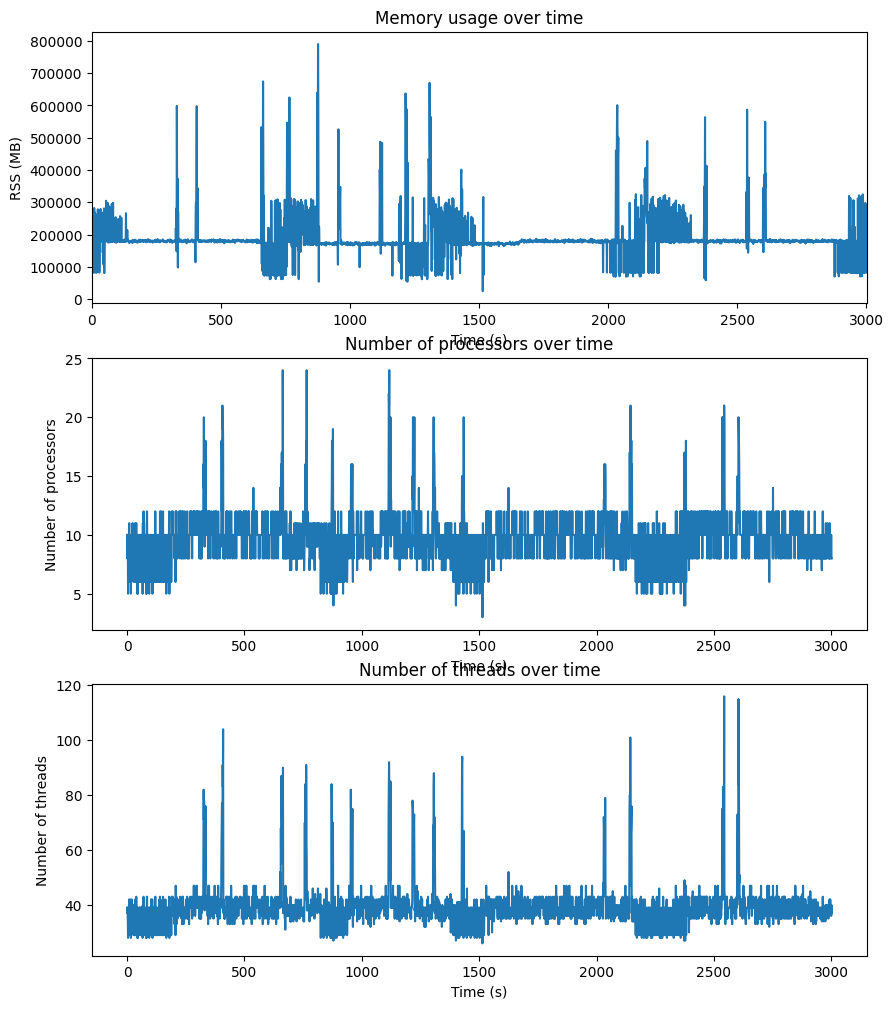

In [78]:
df = pd.read_csv("dataset.csv", delimiter='\t')
anomalies_df = pd.read_csv("anomalies.csv", delimiter=',')

# Unix timestamp to [0, nsamples]
df["Time"] = (df["Time"] - df["Time"].min())

time = df["Time"]
pss = df["pss"]
nprocs = df["nprocs"]
nthreads = df["nthreads"]

plt.figure(figsize=(10, 12))

plt.subplot(3, 1, 1)
plt.plot(time, pss)
plt.xlabel("Time (s)")
plt.ylabel("RSS (MB)")
plt.xlim(0, time.max())
plt.title("Memory usage over time")

plt.subplot(3, 1, 2)
plt.plot(time, nprocs)
plt.xlabel("Time (s)")
plt.ylabel("Number of processors")
plt.title("Number of processors over time")

plt.subplot(3, 1, 3)
plt.plot(time, nthreads)
plt.xlabel("Time (s)")
plt.ylabel("Number of threads")
plt.title("Number of threads over time")

plt.show()

# Detecting anomalies using scikit-learn
We choose to detect anomalies in multivariate time series above with the help of scikit-learn library, as it was advised in the task description. More precisely, we will be using ```IsolationForest``` method. Below plots of 3 metrics observed, predicted anomalies (in red), and true anomalies (green lines):


In [72]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score

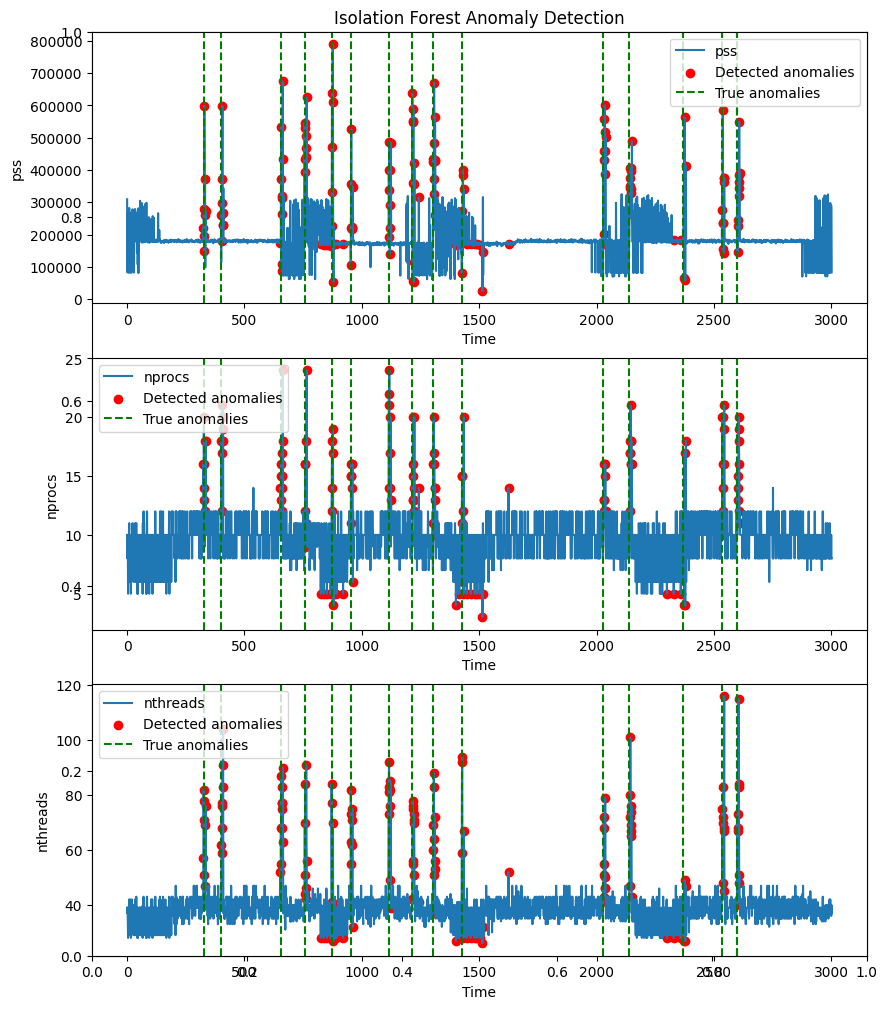

In [74]:
features = ["pss", "nprocs", "nthreads"] # We select 3 features for analysis
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# We use IsolationForest for multivariate anomaly detection
model = IsolationForest(
    n_estimators=200,
    contamination=0.05,
    random_state=42
)
model.fit(X_scaled)
df["anomaly_label"] = model.predict(X_scaled)
df["is_anomaly"] = (df["anomaly_label"] == -1).astype(int)
# 0 - predicted normal regime
# 1 - predicted anomaly

# First and last 10% of our data are supposed to not have any anomalies
df.loc[1:int(len(df) * 0.1), "is_anomaly"] = 0
df.loc[int(len(df) * 0.9):, "is_anomaly"] = 0
df.loc[1:int(len(df) * 0.1), "true_anomaly"] = 0
df.loc[int(len(df) * 0.9):, "true_anomaly"] = 0

# Obtain ground truth from the dataset anomalies_df
true_anomalies = anomalies_df["start_time"].to_numpy()
duration = anomalies_df["duration"]
df["true_anomaly"] = pd.DataFrame(np.zeros(len(df)), columns=['metric_value'])

# Set all time points in each anomaly windows as anomalies
for i, start in enumerate(true_anomalies):
  for j in range(duration[i]):
    df.loc[start + j, "true_anomaly"] = 1


# Visualization
plt.figure(figsize=(10, 12))
plt.title("Isolation Forest Anomaly Detection")
for i, feature in enumerate(features):
  plt.subplot(3, 1, i + 1)
  plt.plot(df["Time"], df[feature], label=feature)

  anomalies = df[df["is_anomaly"] == 1]
  plt.scatter(anomalies["Time"], anomalies[feature],
            color="red", label="Detected anomalies")
  for pt in true_anomalies:
    plt.axvline(x=pt, color='green', linestyle='--')
  plt.axvline(x=true_anomalies[-1], color='green', linestyle='--', label="True anomalies")
  plt.xlabel("Time")
  plt.ylabel(feature)
  plt.legend()

plt.show()


In [75]:
# Detect how many group of anomalous points IsolationForest detects
def anomal_group_count(anomalies_pred, window_length = 10):
  anomalies_pred_ext = anomalies_pred.to_numpy()
  groups = 0
  i = 0
  while i < len(anomalies_pred_ext) - 1:
    if anomalies_pred_ext[i] == 1:
      groups += 1
      i += window_length
    else:
      i += 1
  return groups


In [79]:
def anomalies_covered(anomalies_pred_df, true_anomalies_df):
  anomalies_pred = anomalies_pred_df.to_numpy()
  true_anomalies = true_anomalies_df.to_numpy()
  # Track the first anomaly as a contrast between 0 and 1 in the array
  diff = np.diff(true_anomalies)
  starts = np.where(diff == 1)[0]
  ends = np.where(diff == -1)[0]
  covered = 0
    # Iterate through each true anomaly segment
  for start, end in zip(starts, ends):
        # With np.any, check if the model predicted an anomaly inside this segment
    if np.any(anomalies_pred[start:end] == 1):
        # If so, then the anomaly is considered covered
        covered += 1
  return covered

In [ ]:
# IsolationForest marks each anomalous point, so it makes sense
# to count groups of predicted anomalous points
predicted_anomalies = anomal_group_count(df["is_anomaly"], 10)
print(f"Predicted anomal points group count: {predicted_anomalies}")
print(f"Generated anomalous interval count:{anomaly_count}" )

Below the code that produces key metrics of ```IsolationForest```'s performance:

In [68]:
from sklearn.metrics import confusion_matrix

# Produce performance with confusion matrix
cm = confusion_matrix(df["true_anomaly"], df["is_anomaly"])
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
print("Confusion matrix:\n",cm)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
print("Precision score:", precision)
print("Recall score:", recall)
print("F1 score:", f1)

covered = anomalies_covered(df["is_anomaly"], df["true_anomaly"])
print(f"Real(generated) anomalies covered: {covered}/{anomaly_count}")

Confusion matrix:
 [[2815   38]
 [  39  111]]
Precision score: 0.7449664429530202
Recall score: 0.74
F1 score: 0.7424749163879599
Real(generated) anomalies covered: 15/15


# Suitability of the approach and tradeoffs observed

Using ```IsolationForest``` is justified due to its independence of data distribution (it is non-parametric) and high performance with correlated variables as those in the datset. Moreover, its computational complexity of $O(n)$ allows to use it for large datasets, which are usually produced by high-frequence data, such as in systems monitoring.



Unlike ```AR```-like models, ```IsolationForest``` can be used on multiple variable data series such as the one analized above. On the other hand, using ```IsolationForest``` is more simple than using many other models such as LSTM, which would require PyTorch and a lot of time to train it.

One of tradeoffs of using ```IsolationForest``` is it struggling to detect longer anomalies, as those seem more like a new trend. However, it appears that in process monitoring most anomalies are short-lived and don't last long.
Longer anomalies are most likely to be a regime change, which we don't consider as anomaly. The other option are some system issues that can be detected otherwise. Another small drawback of using it is that it marks some normal regime points as anomalous, which decreases its $F1$ score.


In conclusion, we might say that using this method is well justified, as it was visually able to track all the true anomalies windows, even though giving some amount of false positives and false negatives.